# Bayesian parameter estimation for an irregularly, noisily, and partially sampled non-linear SDE (Lorenz 63 w/ diffusion) via auto-differentiable non-linear filtering and HMC

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for non-linear model. We use the Extended Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.



Notes:

1. In this notebook, we explore the importance of having a **learnable** state noise covariance (with the knowledge that it can help the EKF to have a larger cov than the truth).
   1. It seems that we can learn from **PARTIAL** observations here! Deeper study of this notebook is warranted---committing it now so we don't lose the good result.
   2. One small **CHEAT** is that we use the mean/std of all true states when normalizing/learning the full rhs (from partial observations). We should be able to avoid this step by leveraging `scale` parameters instead.
2. The drift function needs to be constrained so that it does not encourage solutions to leave a compact domain. Commented-out where statements start to do this (i.e., outside of some domain, point the drift inwards)
   1. `adjust_rhs` does 2 things. First, it points the drift vector field inward when the state leaves a pre-defined constraint box [-100, 100] component-wise. Secondly, it constrains the values of the drift vector field itself to be within [-1000, 1000] by applying a clamp.
   2. Despite this, we still sometimes see NN-based drifts that induce NaN marginal loglikelihood. This occurs when the filter attempts to perform the `condition_on` step using a predicted covariance that is highly non-PSD.
      1. Non-PSD predicted covariance matrices come from numerical solutions to ODE-based representations of prediction covariances. The first and second order EKF, for example, integrate the prior covariance through jacobians of the state dynamics; the solution to these ODEs (i.e. Sarkka thesis Equation 3.158) is PSD, but numerical solutions may deviate from this!
      2. Ideas:
         1. Use the `zeroth` order approach, which simply evolves mean dynamics, then adds covariance at the end of a forecast (avoids numerically integrating covariances through time)
         2. Use higher-fidelity ODE integrator (e.g. adaptive step size, smaller steps, etc) with first/second order EKF.
         3. Apply transformations to first/second-order EKF that ensure PSD (but perhaps sacrifice integration accuracy).
3. Need to train on trajectories longer than T=1. Probably T=10 or so is better (note that likelihood from the early parts of the sequence are likely noisy because the system has not yet synchronized.)
4. Need to train for more epochs
5. Need to improve optimization tricks---e.g., gradient clipping by value/norm, learning rate tuning/scheduling, etc.
6. Need to make sure normalization is being effectively both on output data-space and within the RHS of the dynamics
7. May need to tune / learn filter hyperparameters and try EKF/EnKF/UKF etc. (filter hyperparameter learning is not yet supported)

## Setup

In [22]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from matplotlib import pyplot as plt


# use custom src codebase
from utils.plotting_utils import *

# from utils.utils import monotonically_increasing
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

import blackjax


In [23]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.parameters import log_det_jac_constrain
from dynamax.utils.utils import ensure_array_has_batch_dim, pytree_stack

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

## Generate synthetic training data

In [24]:
# Simulate synthetic data from true model
state_dim = 3
emission_dim = 1
num_sequences = 100
T = 20
num_timesteps = int(T / 0.01)
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))
# drop duplicates
t_emissions = jnp.unique(t_emissions)[:,None]

# actually just do uniform spacing
# t_emissions = jnp.linspace(0, T, num_timesteps)[:,None]
num_timesteps = len(t_emissions)
keys = map(jr.PRNGKey, count())

# Create a model with oscillatory dynamics
## GOAL is to only learn parameters of the drift function and assume all other parameters are known.


dynamics_drift = {
    "params": LearnableLorenz63(sigma=10.0, rho=28.0, beta=8/3),
    "props": LearnableLorenz63(sigma=ParameterProperties(),
                               rho=ParameterProperties(),
                               beta=ParameterProperties()) 
}

dynamics_diffusion_coefficient = {
    "params": LearnableMatrix(params=1e-10*jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False))
}

dynamics_diffusion_cov = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

emission_function = {
    "params": LearnableLinear(weights=jnp.eye(emission_dim, state_dim), bias=jnp.zeros(emission_dim)),
    "props": LearnableLinear(weights=ParameterProperties(trainable=False), bias=ParameterProperties(trainable=False))
}

emission_cov = {
    "params": LearnableMatrix(params=jnp.eye(emission_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

initial_mean = {"params": jnp.zeros(state_dim),
                "props": ParameterProperties(trainable=False)}

initial_cov = {"params": 100*jnp.eye(state_dim),
                "props": ParameterProperties(trainable=False, constrainer=RealToPSDBijector())}


true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, true_props = true_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=dynamics_drift,
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

# sample true states and emissions. Using transition_type="path" to solve SDE.
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions)
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions, transition_type="path")
true_states, emissions = true_model.sample_batch(
    true_params, next(keys), num_sequences, num_timesteps, t_emissions, transition_type="path"
)

# compute the log likelihood of the true model
## WARNING: only computing it for the first sequence
# this is to avoid batching for now...
# first_emissions = emissions[0]
# ll_true = true_model.marginal_log_prob(
#     params=true_params, filter_hyperparams=EKFHyperParams(), emissions=first_emissions, t_emissions=t_emissions
# )
# print(f"Log likelihood of true model (approximated by EKF): {-ll_true}")


batch_inputs = ensure_array_has_batch_dim(None, true_model.inputs_shape)
batch_emissions = ensure_array_has_batch_dim(emissions, true_model.emission_shape)
# batch_t_emissions = ensure_array_has_batch_dim(t_emissions, (1,))
batch_t_emissions = jnp.repeat(t_emissions[jnp.newaxis, :, :], batch_emissions.shape[0], axis=0)

for state_order in ["zeroth", "first", "second"]:
    print(f"Computing log likelihood of true model with state order {state_order}")
    filter_hyperparams = EKFHyperParams(state_order=state_order)
    batch_lls = vmap(
        partial(true_model.marginal_log_prob, true_params, filter_hyperparams=filter_hyperparams),
    )(emissions=batch_emissions, t_emissions=batch_t_emissions, inputs=batch_inputs)
    lp = true_model.log_prior(true_params) + batch_lls.sum()
    ll_true = -lp / len(batch_emissions)


# normalize the emissions by subtracting the mean and dividing by the standard deviation
# emissions_std = emissions.std(axis=(0,1))
# emissions_mean = emissions.mean(axis=(0,1))
# emissions = (emissions - emissions_mean) / emissions_std

# normalize the states by subtracting the mean and dividing by the standard deviation
# true_states_std = true_states.std(axis=(0,1))
# true_states_mean = true_states.mean(axis=(0,1))
# true_states = (true_states - true_states_mean) / true_states_std

# compute normalized covariances
# emission_cov_normalized = {
#     "params": LearnableMatrix(params=emission_cov["params"].params / emissions_std**2),
#     "props": emission_cov["props"],
# }

# initial_cov_normalized = {
#     "params": jnp.eye(state_dim),
#     "props": initial_cov["props"]
# }

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Computing log likelihood of true model with state order zeroth
Computing log likelihood of true model with state order first
Computing log likelihood of true model with state order second


In [25]:
def plot_results(emissions, smoothed_emissions, smoothed_emissions_std):
    # all arrays are (T, E) dimensional, T=ntime, E=emission_dim
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emissions.shape[1]):
        plt.plot(t_emissions.squeeze(), emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(t_emissions.squeeze(), smoothed_emissions[:, i] + spc * i, label="smoothed" if i == 0 else None)[
            0
        ]
        plt.fill_between(
            # jnp.arange(num_timesteps),
            t_emissions.squeeze(),
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[:, i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    # plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()

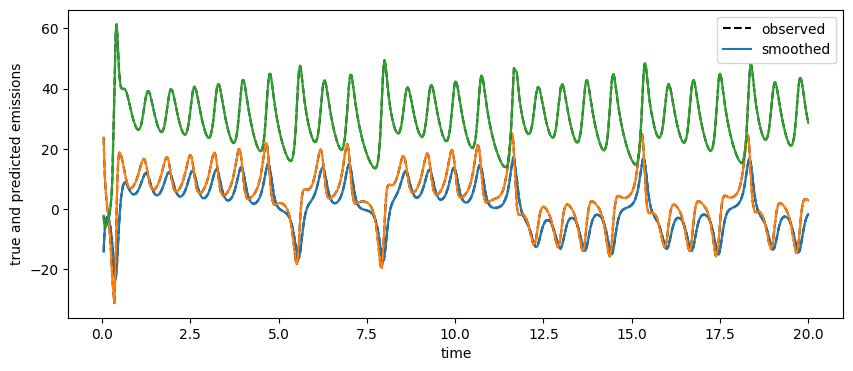

In [26]:
# plot results
plot_results(true_states[0], true_states[0], 0.1 * jnp.ones_like(true_states[0]))  # fake posterior variance

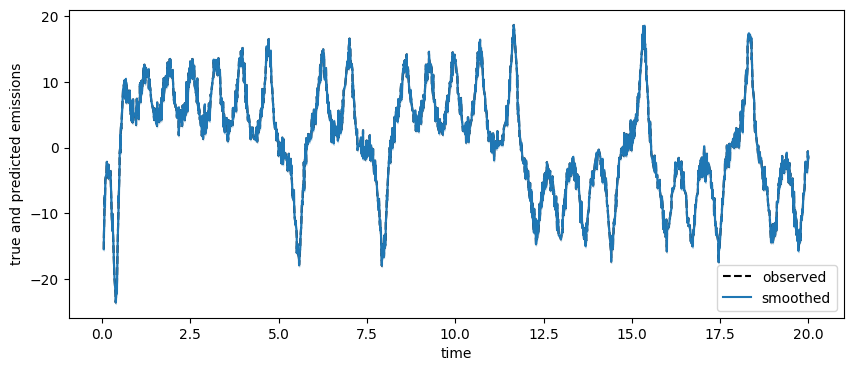

In [27]:
# plot results
plot_results(emissions[0], emissions[0], 0.1 * jnp.ones_like(emissions[0]))  # fake posterior variance

## Create a class for a learnable neural network, which we will use to parameterize the drift function

In [28]:
from typing import NamedTuple, Tuple, Optional, Union
from flax import linen as nn
from jax import jit

# define a normalizer class which stores the mean and standard deviation of the data
# it will have a method to normalize the data and another to denormalize it
class Normalizer(NamedTuple):
    mean: jnp.ndarray
    std: jnp.ndarray

    def normalize(self, data):
        return (data - self.mean) / self.std

    def denormalize(self, data):
        return data * self.std + self.mean

print("Warning: cheating by using the true states mean and std to normalize the states.")
my_normalizer = Normalizer(mean=true_states.mean(axis=(0,1)), std=true_states.std(axis=(0,1)))


@jit
def adjust_rhs(x, rhs, state_lower_bound=-100, state_upper_bound=100,
                rhs_lower_bound=-1000, rhs_upper_bound=1000,
               epsilon=1e-10):
    """
    Adjust the right-hand side of the ODE to ensure that the state 
    remains within the bounds [-100, 100]
    """

    ## NB: Can use jax.lax.clamp to do this more efficiently

    # Use a small epsilon to ensure numerical stability
    # Smoothly adjust the bounds to avoid gradient discontinuities
    safe_lower_bound = jnp.where(x <= state_lower_bound, state_lower_bound + epsilon, x)
    safe_upper_bound = jnp.where(x >= state_upper_bound, state_upper_bound - epsilon, x)

    # Conditionally adjust rhs using the safe bounds
    rhs = jnp.where(safe_lower_bound <= state_lower_bound, jnp.maximum(rhs, 0), rhs)
    rhs = jnp.where(safe_upper_bound >= state_upper_bound, jnp.minimum(rhs, 0), rhs)

    adjust_min = x <= state_lower_bound
    adjust_max = x >= state_upper_bound
    rhs = jnp.where(adjust_min, jnp.maximum(rhs, 0), rhs)
    rhs = jnp.where(adjust_max, jnp.minimum(rhs, 0), rhs)

    # Finally, apply bounds to magnitude of the rhs
    rhs = jnp.clip(rhs, rhs_lower_bound, rhs_upper_bound)

    return rhs


class LearnableNN_TwoLayerGeLU(NamedTuple):
    """Two-layer neural network with Gaussian Error Linear Units
    weights1: weights of the first layer
    bias1: bias of the first layer
    weights2: weights of the second layer
    bias2: bias of the second layer

    f(x) = weights2 @ gelu(weights1 @ x + bias1) + bias2
    """

    weights1: Union[Float[Array, "hidden_dim input_dim"], ParameterProperties]
    bias1: Union[Float[Array, "hidden_dim"], ParameterProperties]
    weights2: Union[Float[Array, "output_dim hidden_dim"], ParameterProperties]
    bias2: Union[Float[Array, "output_dim"], ParameterProperties]
    scale: Union[Float, ParameterProperties]

    def f_1(self, x, u=None, t=None):
        '''This rhs operates in original space, so we need to normalize the input x first.'''

        # # first, clamp all x components to be within [-100, 100]
        # x = jnp.clip(x, -100, 100)
        x_normalized = my_normalizer.normalize(x)

        # compute derivative given by NN
        rhs = self.weights2 @ nn.gelu(self.weights1 @ x_normalized + self.bias1) + self.bias2

        # un-normalize the rhs and multiply by 10^scale
        rhs = rhs * my_normalizer.std * jnp.power(10, self.scale)

        return rhs
        
    def f(self, x, u=None, t=None):
        '''This rhs operates in original space, so we need to normalize the input x first.'''

        rhs = self.f_1(x, u, t)
        
        return adjust_rhs(x, rhs)

## Build initial weights and biases for Neural Network drift function

In [29]:
# Draw weights and biases from a normal distribution with hidden_dim=64, input_dim=state_dim, output_dim=state_dim
hidden_dim = 50
nn_drift = {
    "params": LearnableNN_TwoLayerGeLU(
        weights1=jnp.sqrt(2.0 / state_dim) * jr.normal(next(keys), (hidden_dim, state_dim)),
        bias1=jnp.zeros((hidden_dim,)),
        weights2=jnp.sqrt(2.0 / hidden_dim) * jr.normal(next(keys), (state_dim, hidden_dim)),
        bias2=jnp.zeros((state_dim,)),
        scale=jnp.zeros(())
    ),
    "props": LearnableNN_TwoLayerGeLU(
        weights1=ParameterProperties(trainable=True),
        bias1=ParameterProperties(trainable=True),
        weights2=ParameterProperties(trainable=True),
        bias2=ParameterProperties(trainable=True),
        scale=ParameterProperties(trainable=True)
    ),
}

### Check that NN-based drift is a bounded function (i.e. adjust_rhs works)

In [30]:
for c in [1, 1e10, 200, -200]:
    xx = c * jnp.ones(state_dim)
    print("x:", xx)
    print("f1:", nn_drift["params"].f_1(xx))
    print("f_adjusted:", nn_drift["params"].f(xx))
    print("")

x: [1. 1. 1.]
f1: [-0.42492488  8.793997   -5.482636  ]
f_adjusted: [-0.42492488  8.793997   -5.482636  ]

x: [1.e+10 1.e+10 1.e+10]
f1: [ 1.6769262e+10  1.0732609e+10 -1.0769179e+10]
f_adjusted: [    0.     0. -1000.]

x: [200. 200. 200.]
f1: [ 305.71228  205.6141  -221.22644]
f_adjusted: [   0.         0.      -221.22644]

x: [-200. -200. -200.]
f1: [-221.19699     11.653897    -2.6020472]
f_adjusted: [ 0.       11.653897  0.      ]



## Baseline method: use SGD to compute MLE

In [31]:
# Initilize parameters by fitting SGD algorithm
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import *
from continuous_discrete_nonlinear_gaussian_ssm.models import *
num_epochs = 200

# filter_hyperparams = EnKFHyperParams(N_particles=30)
filter_hyperparams = EKFHyperParams(state_order='zeroth')

test_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

# learn the diff coeff and start it at 10 times the true value
dynamics_diffusion_coefficient_larger = {
    "params": LearnableMatrix(params=1*jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(trainable=True)),
}

initial_params, param_props = test_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=nn_drift,  # ONLY DIFFERENCE FROM TRUE MODEL
    # dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient_larger,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

import optax

# define a learning rate scheduler
initial_learning_rate = 1e-1
decay_factor = 0.1  # Decay the learning rate by a factor of 10
epochs_per_step = 100  # Number of epochs per decay step

# Define the boundaries where the decay should happen
# In this case, every 20 epochs
boundaries = [epochs_per_step * i for i in range(1, num_epochs // epochs_per_step + 1)]

# Define the values of the learning rates at each boundary
values = [initial_learning_rate * (decay_factor**i) for i in range(len(boundaries) + 1)]

# Create a step decay learning rate schedule
scheduler = optax.piecewise_constant_schedule(
    init_value=initial_learning_rate, boundaries_and_scales={boundary: decay_factor for boundary in boundaries}
)

# define an optimizer with a learning rate of 1e-1 and gradient clipping
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    optax.scale(-1.0),
)

filter_hyperparams = EKFHyperParams(state_order='zeroth', cov_rescaling=1)
fitted_params, fitted_params_history, grad_history, marginal_lls = true_model.fit_sgd(
    # true_params,
    # true_props,
    initial_params,
    param_props,
    emissions,
    filter_hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
    num_epochs=num_epochs,
    optimizer=optimizer,
    return_param_history=True,
    return_grad_history=True,
    batch_size=num_sequences,
)

In [32]:
param_props.dynamics.diffusion_coefficient.params.trainable

True

In [75]:
f = tree_map(lambda x: x[-1], fitted_params_history).dynamics.drift.f
f(10*jnp.ones(state_dim)), f(jnp.ones(state_dim)), f(jnp.zeros(state_dim))

(Array([  86.06624 , -139.80197 ,  -50.542065], dtype=float32),
 Array([ 22.486473, -50.54929 , 108.05085 ], dtype=float32),
 Array([ 18.798988, -37.902313, 126.70383 ], dtype=float32))

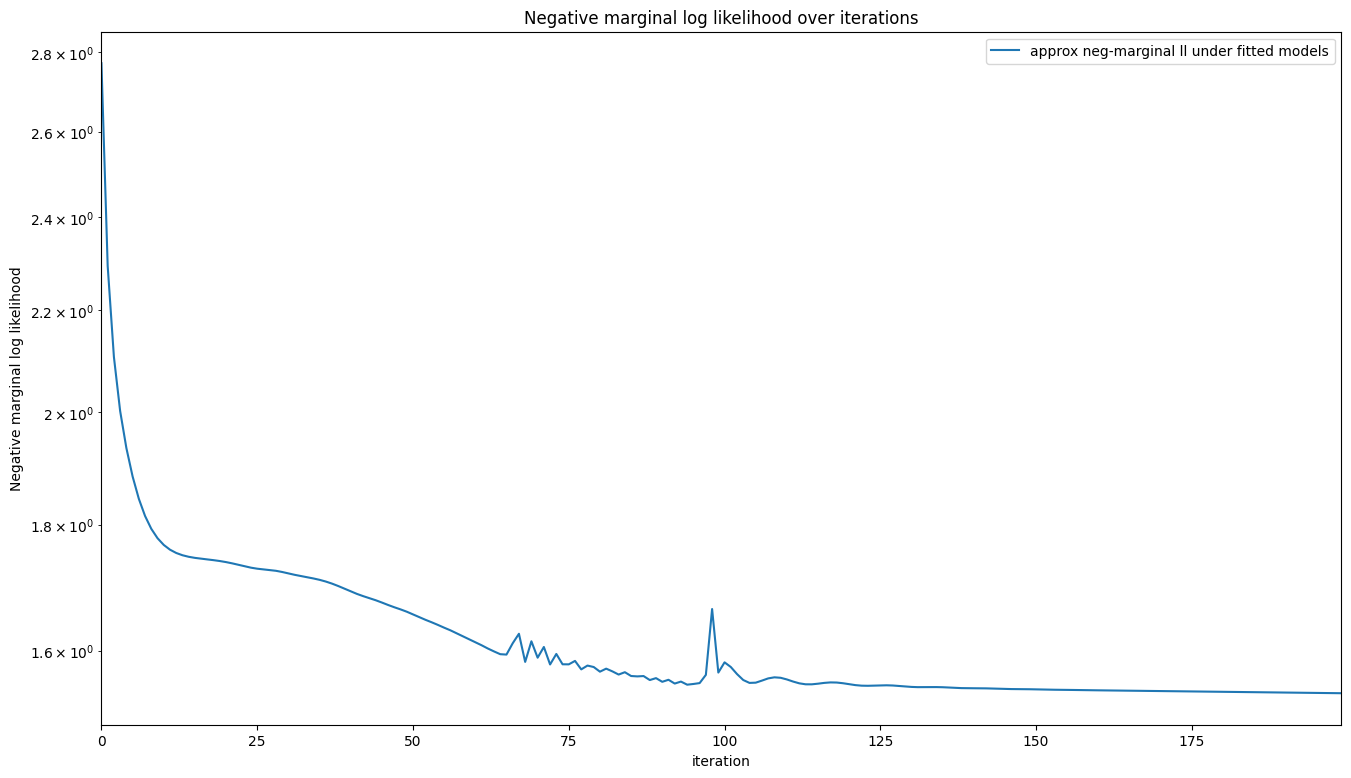

In [36]:
# plot the marginal lls over iterations for SGD
plt.plot(marginal_lls, label="approx neg-marginal ll under fitted models")
# plt.axhline(ll_true, color="red", linestyle="--", label="approx neg-marginal ll under true model")
plt.xlabel("iteration")
plt.ylabel("Negative marginal log likelihood")
plt.yscale("log")
plt.autoscale(enable=True, axis="x", tight=True)
plt.title("Negative marginal log likelihood over iterations")
plt.legend()


Text(0.5, 1.0, 'Learned diffusion coefficient over iterations')

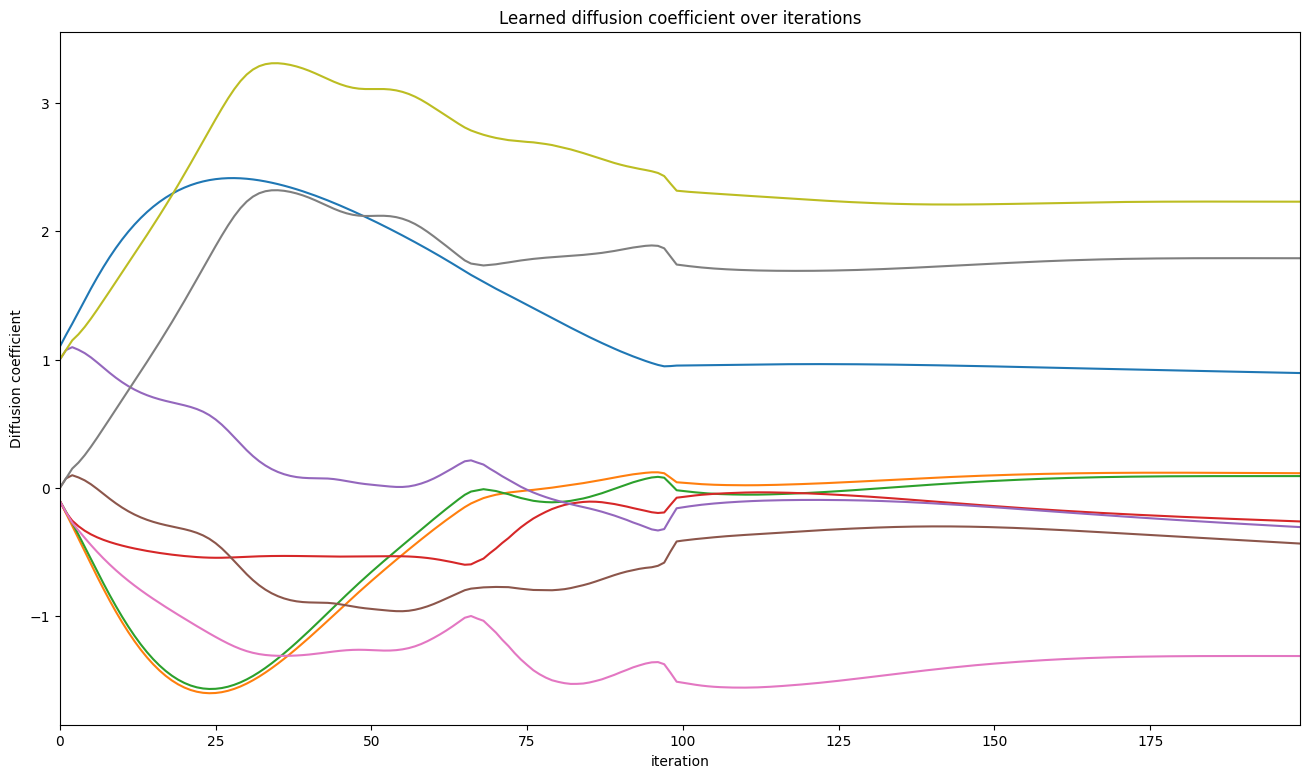

In [72]:
# plot the sequence of learned diffusion coefficients
# to get a particular params do 
# params_i = tree_map(lambda x: x[i].dynamics.diffusion_coefficient.params, fitted_params_history)
# then vmap over the iterations to collect all of them
diffusion_coefficients = vmap(lambda x: x.dynamics.diffusion_coefficient.params)(fitted_params_history)
scale_factors = vmap(lambda x: x.dynamics.drift.scale)(fitted_params_history)
# this is 200 iters x (3x3 matrix)
# plot the determinant of the diffusion coefficient
# plt.plot(jnp.linalg.det(diffusion_coefficients), label="determinant of diffusion coefficient")
# plot each element of the diffusion coefficient
for i in range(3):
    for j in range(3):
        plt.plot(diffusion_coefficients[:, i, j], label=f"diffusion coefficient {i}, {j}")

# plt.plot(scale_factors, label="scale factor")
plt.xlabel("iteration")
plt.ylabel("Diffusion coefficient")
plt.autoscale(enable=True, axis="x", tight=True)
plt.title("Learned diffusion coefficient over iterations")

In [67]:
diffusion_coefficients.shape

(200, 3, 3)

Text(0.5, 0, 'time')

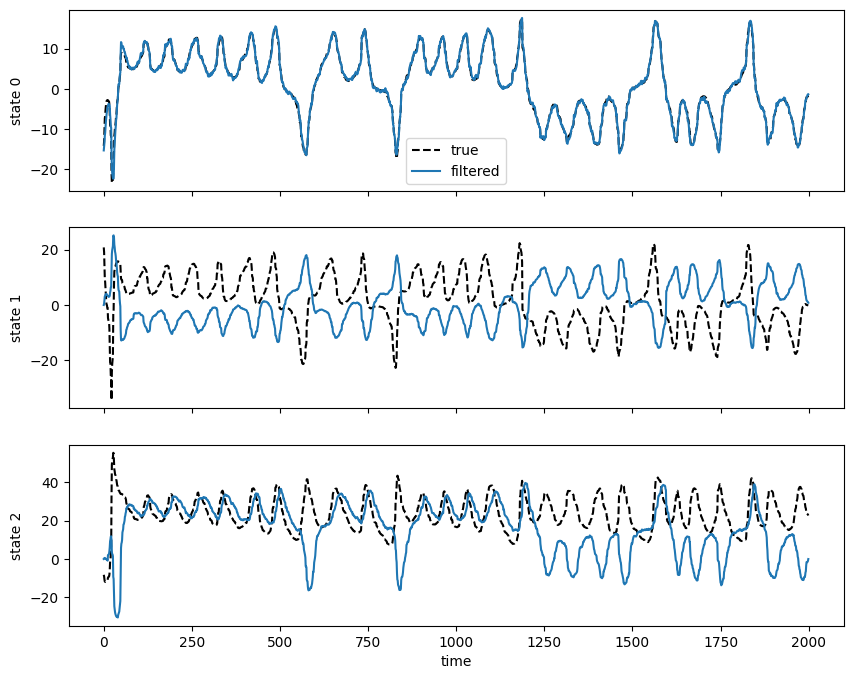

In [76]:
ind_emissions = 0

filtered_posterior = cdnlgssm_filter(
    params=fitted_params,
    emissions=emissions[ind_emissions],
    hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
)
# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(true_states[ind_emissions, :, i], "--k", label="true" if i == 0 else None)
    axs[i].plot(filtered_posterior.filtered_means[:, i], label="filtered" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()
axs[-1].set_xlabel("time")

In [38]:
filtered_posterior.predicted_covariances[0], filtered_posterior.predicted_covariances[1], filtered_posterior.predicted_covariances[-1]

(Array([[ 1.0376060e+00, -1.7814530e-02, -4.3918103e-02],
        [-1.7814530e-02,  1.0002012e+02, -6.7532785e-02],
        [-4.3918096e-02, -6.7532785e-02,  1.0057109e+02]], dtype=float32),
 Array([[ 5.9153008e-01, -3.9587498e-02, -9.7594932e-02],
        [-3.9587498e-02,  1.0005480e+02, -1.8484510e-01],
        [-9.7594917e-02, -1.8484510e-01,  1.0155895e+02]], dtype=float32),
 Array([[ 2.1612649e-01, -8.0998294e-02, -1.9968481e-01],
        [-8.0998294e-02,  1.4128807e+02, -2.5745917e+02],
        [-1.9968481e-01, -2.5745917e+02,  1.7275347e+03]], dtype=float32))

In [39]:
# plot determinant of filtered covariance over time
filtered_covs_det = jnp.linalg.det(filtered_posterior.filtered_covariances)
filtered_covs_det.shape

(2000,)

### Plot a long forward sim of the model---unless the model is trained well, this often decays to a fixed point or blows up

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


Text(0.5, 0, 'time')

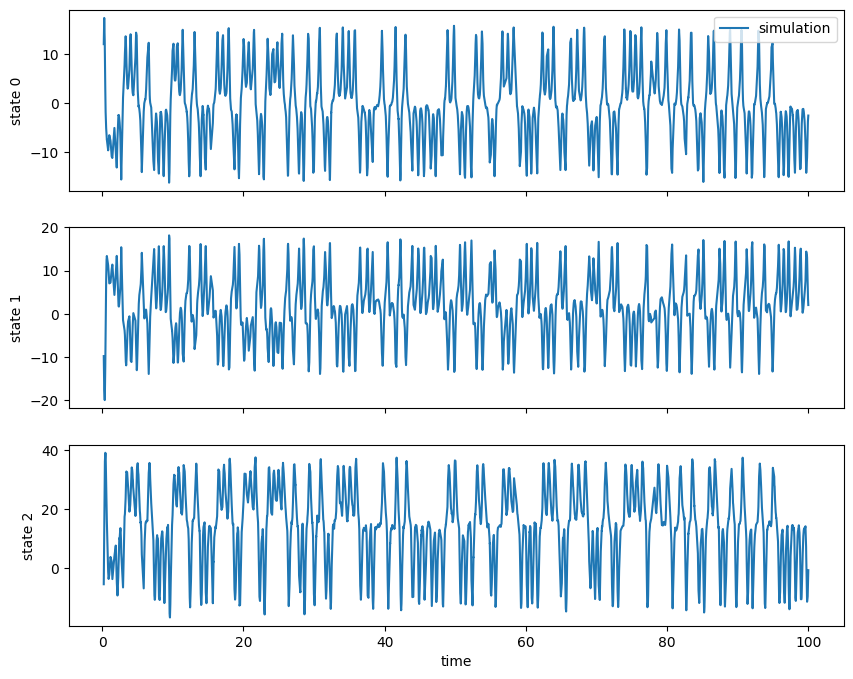

In [40]:
from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain
from dynamax.utils.utils import ensure_array_has_batch_dim, pytree_stack
from jax import lax, value_and_grad, tree_map

params = tree_map(lambda x: x[-1], fitted_params_history)

batch_inputs = ensure_array_has_batch_dim(None, test_model.inputs_shape)
batch_emissions = ensure_array_has_batch_dim(emissions, test_model.emission_shape)
# batch_t_emissions = ensure_array_has_batch_dim(t_emissions, (1,))
batch_t_emissions = jnp.repeat(t_emissions[jnp.newaxis, :, :], batch_emissions.shape[0], axis=0)


# duplicate t_emissions for each sequence
# batch_t_emissions = jnp.tile(t_emissions, (num_sequences, 1, 1))
T = 100
dt = 0.01
num_timesteps_long = int(T / dt)
t_emissions_long = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))


sim_states, sim_emissions = test_model.sample(
    params,
    key=next(keys),
    num_timesteps=num_timesteps_long,
    t_emissions=t_emissions_long,
    transition_type="path",
)

# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(t_emissions_long.squeeze(), sim_states[:, i], label="simulation" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()
axs[-1].set_xlabel("time")

In [41]:
jnp.mean(true_states, axis=(0,1)), jnp.std(true_states, axis=(0,1))

(Array([ 0.48687267,  0.49762526, 24.38869   ], dtype=float32),
 Array([8.116992 , 9.038536 , 7.9360313], dtype=float32))

In [42]:
from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain
from dynamax.utils.utils import ensure_array_has_batch_dim, pytree_stack
from jax import lax, value_and_grad, tree_map

params = tree_map(lambda x: x[-1], fitted_params_history)

batch_inputs = ensure_array_has_batch_dim(None, test_model.inputs_shape)
batch_emissions = ensure_array_has_batch_dim(emissions, test_model.emission_shape)
# batch_t_emissions = ensure_array_has_batch_dim(t_emissions, (1,))
batch_t_emissions = jnp.repeat(t_emissions[jnp.newaxis, :, :], batch_emissions.shape[0], axis=0)


# duplicate t_emissions for each sequence
# batch_t_emissions = jnp.tile(t_emissions, (num_sequences, 1, 1))
T = 100
dt = 0.01
num_timesteps_long = int(T / dt)
t_emissions_long = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))


def _sample_long(params):
    return test_model.sample(
        params,
        key=next(keys),
        num_timesteps=num_timesteps_long,
        t_emissions=t_emissions_long,
        transition_type="path",
    )


def _loss_fn(my_params):
    states, emissions = test_model.sample(
        my_params,
        key=next(keys),
        num_timesteps=num_timesteps_long,
        t_emissions=t_emissions_long,
        transition_type="path",
    )
    return emissions.mean()


loss_grad_fn = value_and_grad(_loss_fn)
this_loss, grads = loss_grad_fn(params)
print(this_loss)
print(jnp.max(jnp.abs(grads.dynamics.drift.bias2)))
print(jnp.max(jnp.abs(grads.dynamics.drift.bias1)))
print(jnp.max(jnp.abs(grads.dynamics.drift.weights1)))
print(jnp.max(jnp.abs(grads.dynamics.drift.weights2)))

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
-1.1073494
nan
nan
nan
nan


### Make very long simulation and plot the histograms.


Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


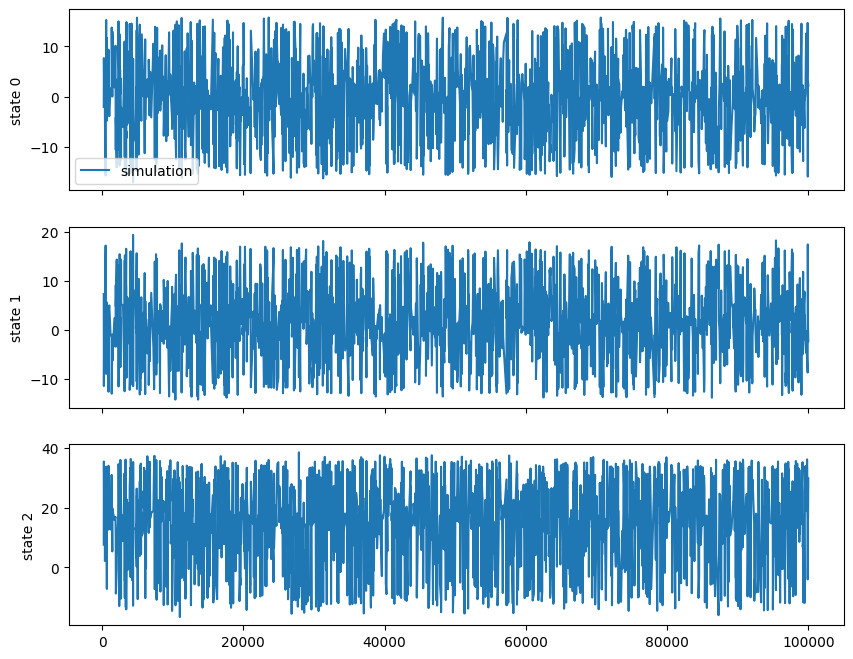

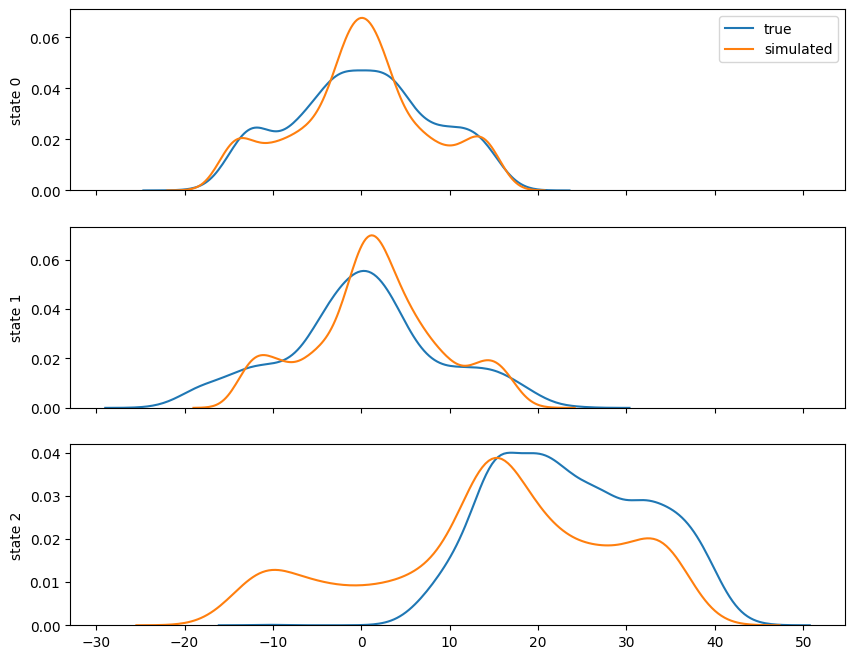

In [63]:
T = 1e5
dt = 0.01
num_timesteps_long = int(T / dt)
t_emissions_long = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

longest_states_sim, longest_emissions_sim = test_model.sample(
    fitted_params,
    key=next(keys),
    num_timesteps=num_timesteps_long,
    t_emissions=t_emissions_long,
    transition_type="path"
)

# run the same simulation with the true model
longest_states_true, longest_emissions_true = true_model.sample(
    true_params,
    key=next(keys),
    num_timesteps=num_timesteps_long,
    t_emissions=t_emissions_long,
    transition_type="path"
)

# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(t_emissions_long.squeeze(), longest_states_sim[:, i], label="simulation" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()

# now plot KDE of the simulated emissions vs the true emissions
# make sure if emission_dim = 1, we can still plot (use setting to ensure axs is a list)
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    ax = axs[i]
    sns.kdeplot(longest_states_true[..., i].reshape(-1,1).squeeze(), ax=ax, label="true")
    sns.kdeplot(longest_states_sim[:, i].squeeze(), ax=ax, label="simulated")
    ax.set_ylabel(f"state {i}")
    if i == 0:
        ax.legend()